First few rows of the dataset:
    latitude  longitude        wardname     lganame statename  \
0  11.822320  13.148320      Maisandari   Maiduguri     Borno   
1  11.821615  13.147176      Maisandari   Maiduguri     Borno   
2  10.707092  12.816284           Ngohi  Askira Uba     Borno   
3  10.615220  12.181628       Galdimari         Biu     Borno   
4  10.759527  13.313358  Ngurthavu Kopa  Askira Uba     Borno   

                category                                       ownership  \
0  Primary Health Center                                         Private   
1  Primary Health Center  National Primary Healthcare Development Agency   
2  Primary Health Center     State Primary Healthcare Development Agency   
3  Primary Health Center                                          Others   
4             Dispensary                                          Others   

      type            func_stats  
0  Primary               Unknown  
1  Primary            Functional  
2  Primary  Part

<Figure size 1200x600 with 0 Axes>

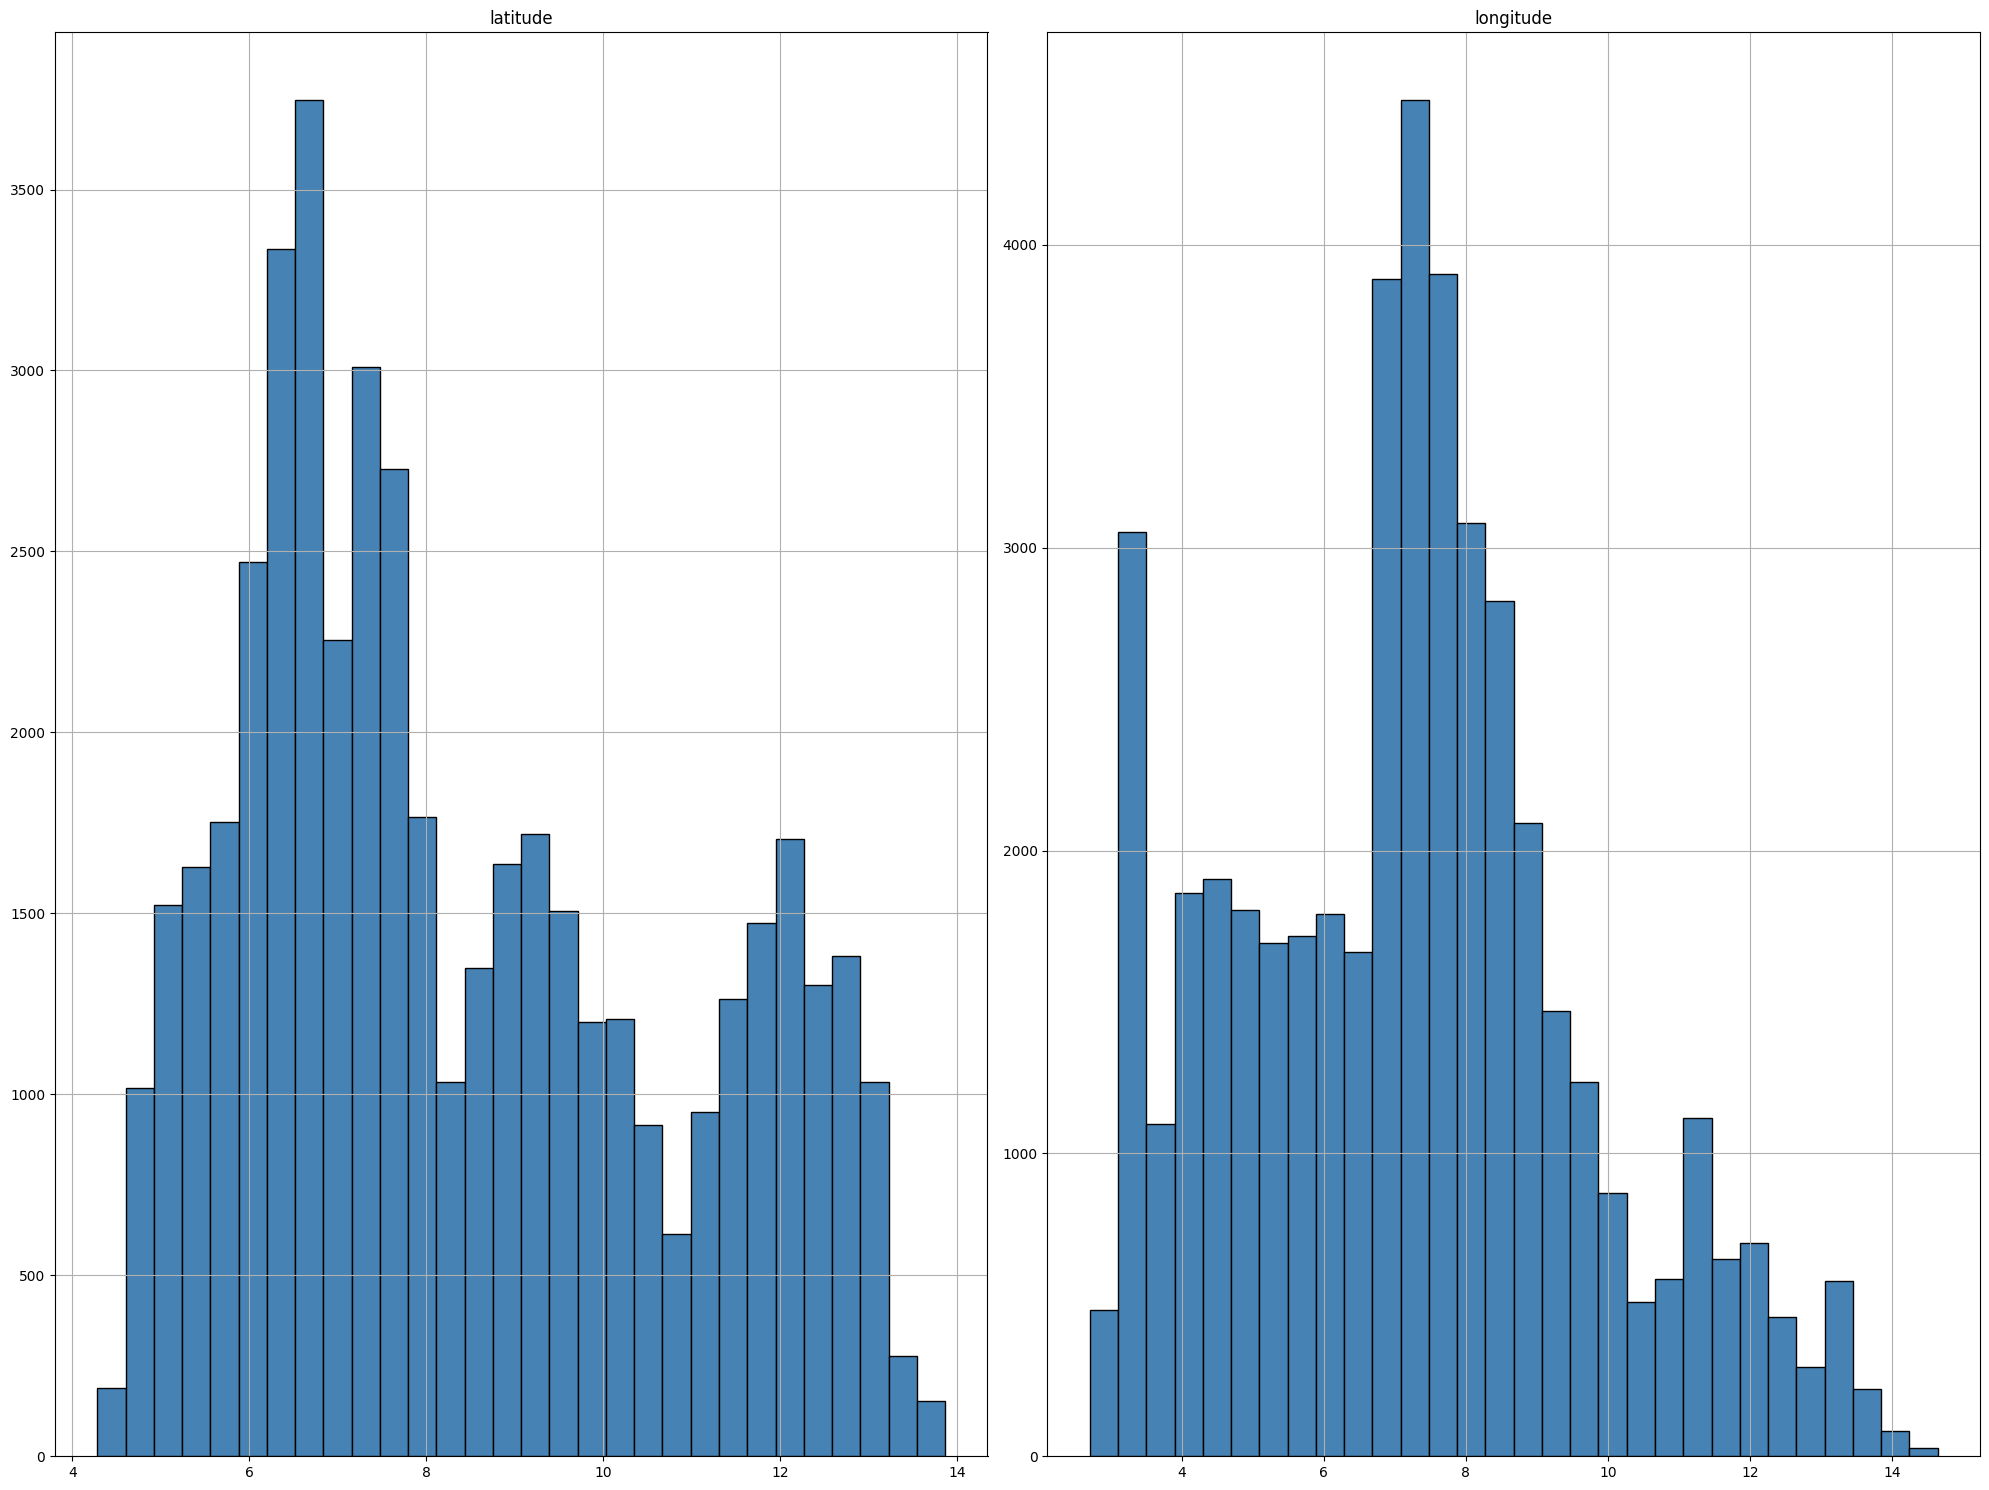

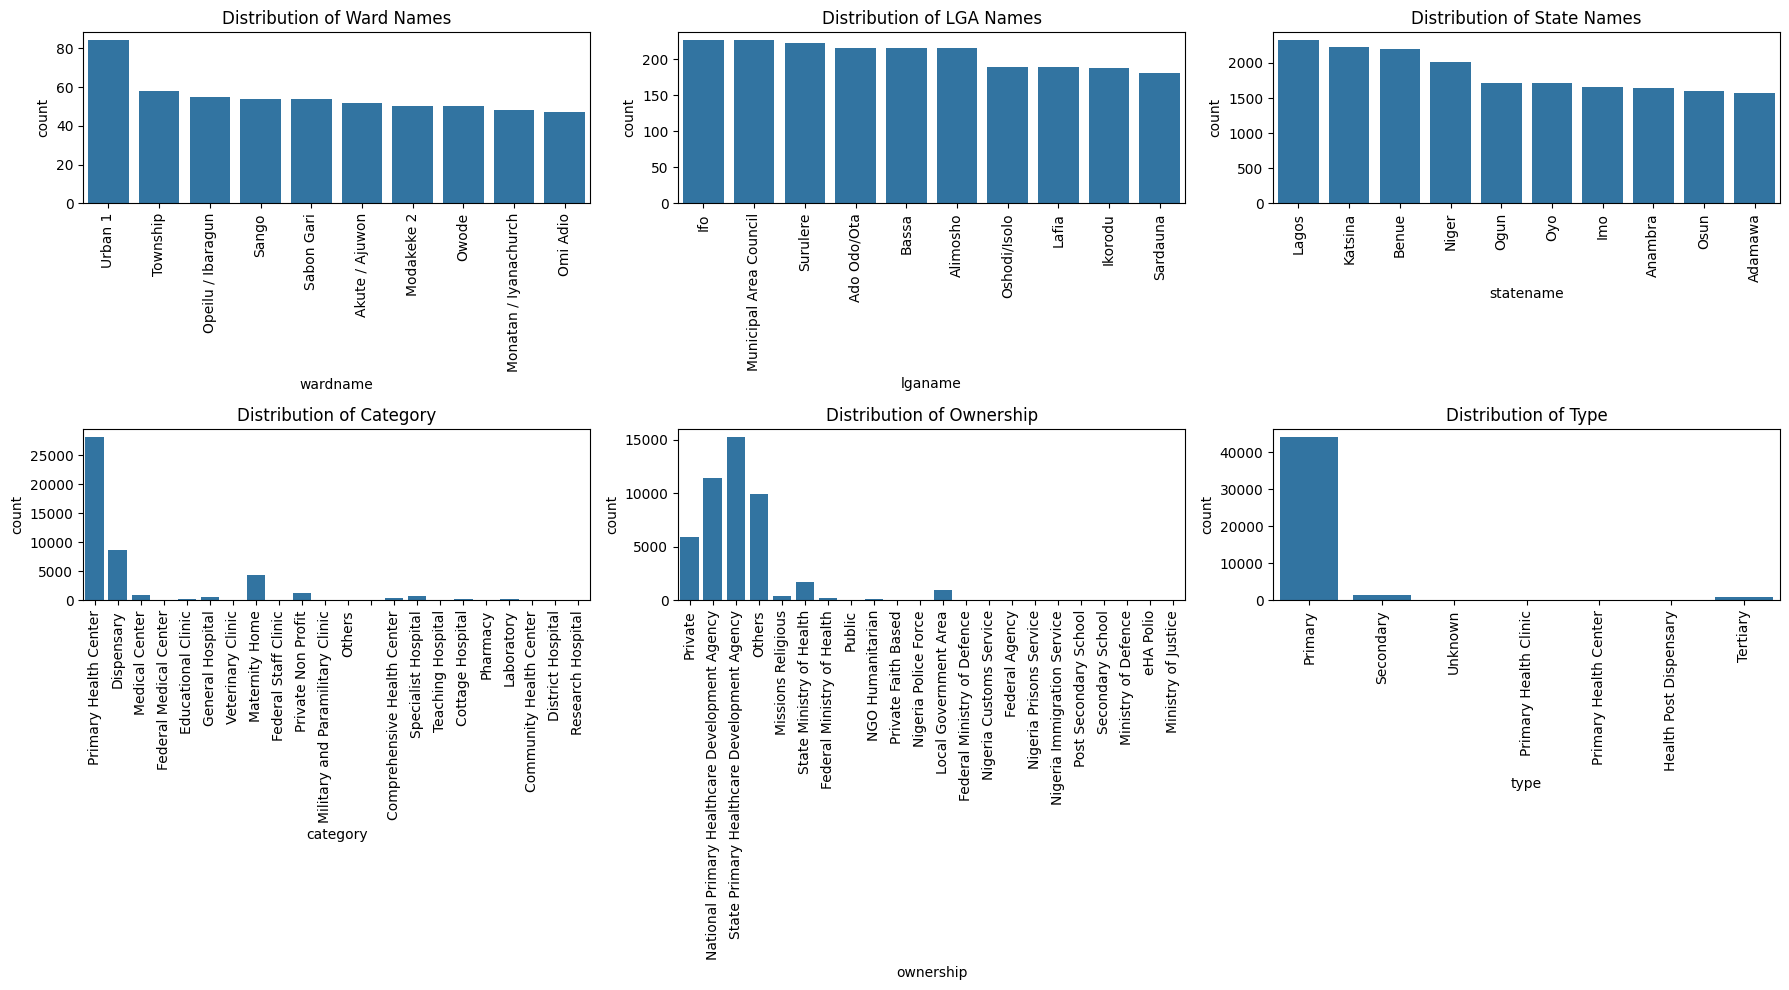

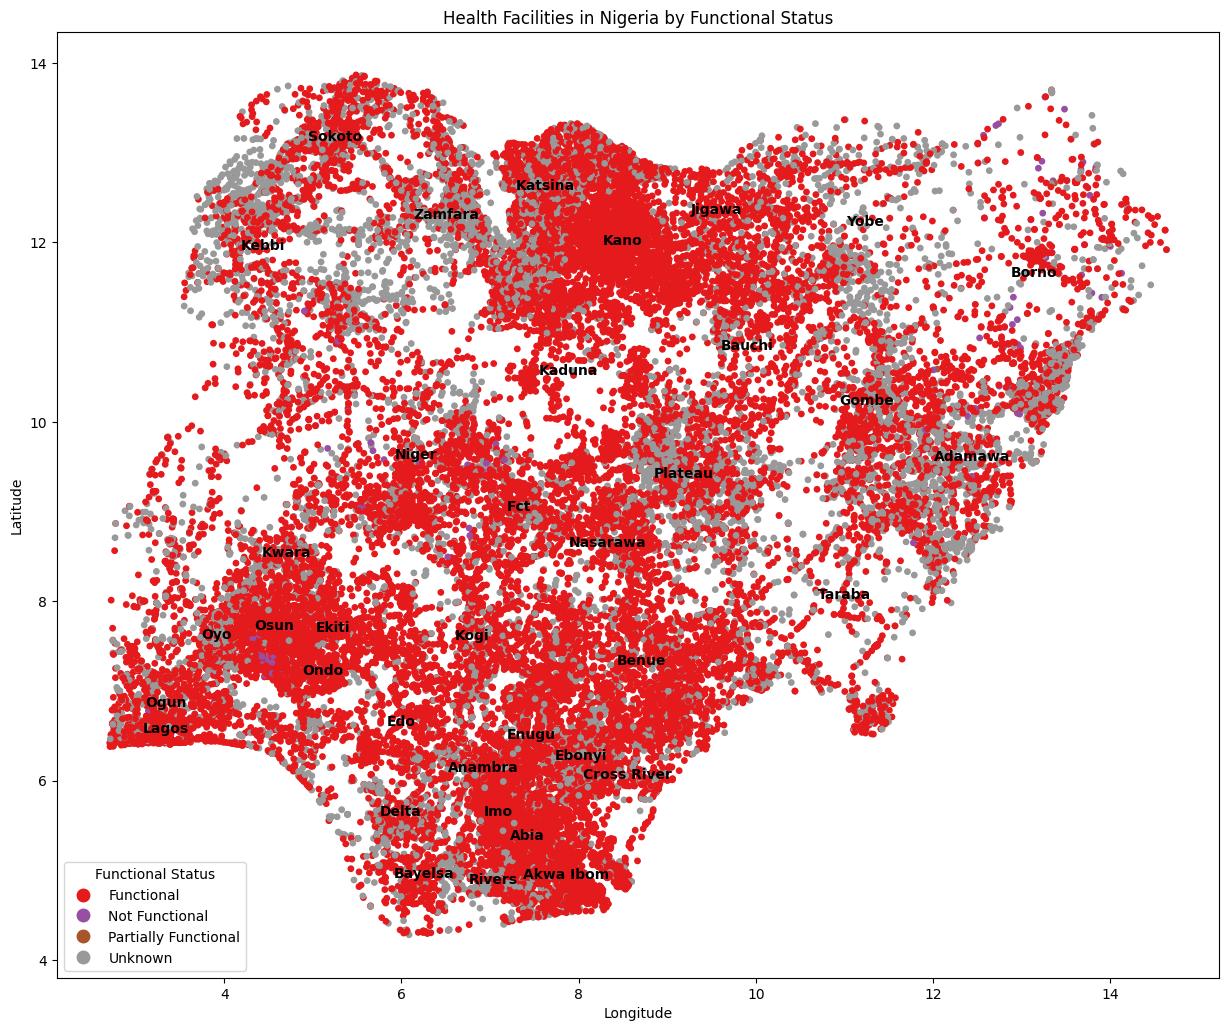

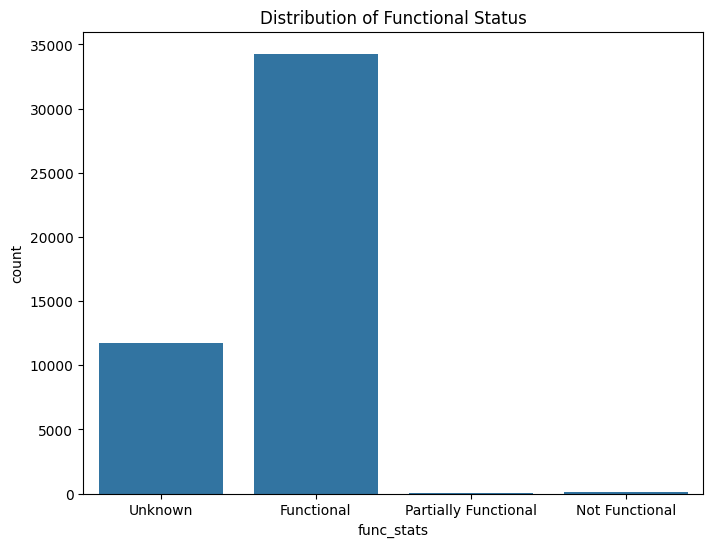

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

# Load your dataset
data = pd.read_csv('/Users/lilianngonadi/Downloads/GRID3_NGA_-_Health_Facilities_.csv')

# Select the relevant columns with correct names
columns_of_interest = ['latitude', 'longitude', 'wardname', 'lganame', 'statename', 'category', 'ownership', 'type', 'func_stats']
data_selected = data[columns_of_interest].copy()

# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(data_selected.head())

# Display basic statistics
print("\nBasic statistics of the dataset:")
print(data_selected.describe())

# Check for missing values
print("\nMissing values in the dataset:")
print(data_selected.isnull().sum())

# Visualize the distribution of the numerical features
plt.figure(figsize=(12, 6))
data_selected.hist(bins=30, figsize=(20, 15), color='steelblue', edgecolor='black')
plt.tight_layout()
plt.show()


# Visualize the distribution of the categorical features
plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
sns.countplot(data=data_selected, x='wardname', order=data_selected['wardname'].value_counts().iloc[:10].index)
plt.xticks(rotation=90)
plt.title('Distribution of Ward Names')

plt.subplot(2, 3, 2)
sns.countplot(data=data_selected, x='lganame', order=data_selected['lganame'].value_counts().iloc[:10].index)
plt.xticks(rotation=90)
plt.title('Distribution of LGA Names')

plt.subplot(2, 3, 3)
sns.countplot(data=data_selected, x='statename', order=data_selected['statename'].value_counts().iloc[:10].index)
plt.xticks(rotation=90)
plt.title('Distribution of State Names')

plt.subplot(2, 3, 4)
sns.countplot(data=data_selected, x='category')
plt.xticks(rotation=90)
plt.title('Distribution of Category')

plt.subplot(2, 3, 5)
sns.countplot(data=data_selected, x='ownership')
plt.xticks(rotation=90)
plt.title('Distribution of Ownership')

plt.subplot(2, 3, 6)
sns.countplot(data=data_selected, x='type')
plt.xticks(rotation=90)
plt.title('Distribution of Type')

plt.tight_layout()
plt.show()

# Create a GeoDataFrame for the health facilities
gdf_facilities = gpd.GeoDataFrame(
    data_selected,
    geometry=gpd.points_from_xy(data_selected.longitude, data_selected.latitude),
    crs="EPSG:4326"
)

# Plot the facilities on the map of Nigeria
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
gdf_facilities.plot(ax=ax, column='func_stats', cmap='Set1', legend=True, markersize=15, legend_kwds={'title': 'Functional Status'})
plt.title('Health Facilities in Nigeria by Functional Status')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add state names to the scatter plot
for state in data_selected['statename'].unique():
    state_data = data_selected[data_selected['statename'] == state]
    if not state_data.empty:
        plt.text(state_data['longitude'].median(), state_data['latitude'].median(), state, 
                 horizontalalignment='center', size='medium', color='black', weight='semibold')

plt.show()

# Analyze the target variable distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=data_selected, x='func_stats')
plt.title('Distribution of Functional Status')
plt.show()


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

# Load your dataset
data = pd.read_csv('/Users/lilianngonadi/Downloads/GRID3_NGA_-_Health_Facilities_.csv')

# Select the relevant columns with correct names
columns_of_interest = ['latitude', 'longitude', 'wardname', 'lganame', 'statename', 'category', 'ownership', 'type', 'func_stats']
data_selected = data[columns_of_interest].copy()

# Check for missing values and handle them (if any)
data_selected = data_selected.dropna()

# Encode categorical variables
label_encoders = {}
for column in ['wardname', 'lganame', 'statename', 'category', 'ownership', 'type']:
    le = LabelEncoder()
    data_selected[column] = le.fit_transform(data_selected[column].astype(str))
    label_encoders[column] = le

# Split the data into features and target
X = data_selected.drop('func_stats', axis=1)
y = data_selected['func_stats']

# Encode target variable
le_target = LabelEncoder()
y = le_target.fit_transform(y)

# Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Initialize the XGBoost classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Set up the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', xgb_clf)
])

# Set up the expanded parameter grid for GridSearchCV
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [5],
    'classifier__learning_rate': [0.2, 0.3],
    'classifier__subsample': [1.0],
    'classifier__colsample_bytree': [1.0],
    'classifier__min_child_weight': [5, 7],
    'classifier__reg_alpha': [0.1],  # L1 regularization term (Lasso)
    'classifier__reg_lambda': [1.0],
}

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_weighted', verbose=1, n_jobs=-1)

# Train the classifier
grid_search.fit(X_train, y_train)

# Make predictions
y_pred = grid_search.predict(X_test)

# Generate the classification report
classification_rep = classification_report(y_test, y_pred, target_names=le_target.classes_)
confusion_mat = confusion_matrix(y_test, y_pred)

print("Best parameters found: ", grid_search.best_params_)
print(classification_rep)
print(confusion_mat)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:31:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:31:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:31:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:31:48] WARNING: /Users/runner/work/xgboost/xgboost/src

Best parameters found:  {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.3, 'classifier__max_depth': 7, 'classifier__min_child_weight': 5, 'classifier__n_estimators': 200, 'classifier__reg_alpha': 0.1, 'classifier__reg_lambda': 1.0, 'classifier__subsample': 1.0}
                      precision    recall  f1-score   support

          Functional       0.87      0.83      0.85      6914
      Not Functional       0.99      1.00      0.99      6812
Partially Functional       1.00      1.00      1.00      6806
             Unknown       0.84      0.87      0.86      6894

            accuracy                           0.93     27426
           macro avg       0.93      0.93      0.93     27426
        weighted avg       0.93      0.93      0.93     27426

[[5762   27    4 1121]
 [   5 6803    0    4]
 [   0    0 6806    0]
 [ 847   43    0 6004]]


In [7]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
# Evaluate the model
classification_rep = classification_report(y_test, y_pred, target_names=le_target.classes_)
confusion_mat = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print("Best parameters found: ", grid_search.best_params_)
print("\nClassification Report:\n", classification_rep)
print("\nConfusion Matrix:\n", confusion_mat)
print(f"\nAccuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

Best parameters found:  {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.3, 'classifier__max_depth': 7, 'classifier__min_child_weight': 5, 'classifier__n_estimators': 200, 'classifier__reg_alpha': 0.1, 'classifier__reg_lambda': 1.0, 'classifier__subsample': 1.0}

Classification Report:
                       precision    recall  f1-score   support

          Functional       0.87      0.83      0.85      6914
      Not Functional       0.99      1.00      0.99      6812
Partially Functional       1.00      1.00      1.00      6806
             Unknown       0.84      0.87      0.86      6894

            accuracy                           0.93     27426
           macro avg       0.93      0.93      0.93     27426
        weighted avg       0.93      0.93      0.93     27426


Confusion Matrix:
 [[5762   27    4 1121]
 [   5 6803    0    4]
 [   0    0 6806    0]
 [ 847   43    0 6004]]

Accuracy: 0.9252
F1 Score: 0.9250


In [8]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(pipeline, X_res, y_res, cv=cv, scoring='f1_weighted', n_jobs=-1)

# Print cross-validation scores
print("Cross-validation F1 scores: ", cv_scores)
print("Mean F1 score: ", cv_scores.mean())
print("Standard deviation of F1 scores: ", cv_scores.std())

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:34:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:34:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:34:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:34:41] WARNING: /Users/runner/work/xgboost/xgboost/src

Cross-validation F1 scores:  [0.91702394 0.91642533 0.92042763 0.91508696 0.91708907]
Mean F1 score:  0.9172105848449638
Standard deviation of F1 scores:  0.0017621251451143479


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:36:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:36:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:36:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:36:14] WARNING: /Users/runner/work/xgboost/xgboost/src

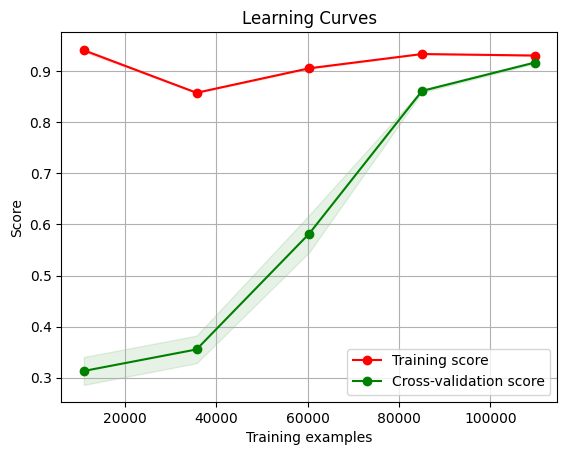

In [9]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_sizes, train_scores, test_scores = learning_curve(pipeline, X_res, y_res, cv=cv, scoring='f1_weighted', n_jobs=-1)

train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_mean = test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)

plt.figure()
plt.title("Learning Curves")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:37:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:37:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:37:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:37:10] WARNING: /Users/runner/work/xgboost/xgboost/src

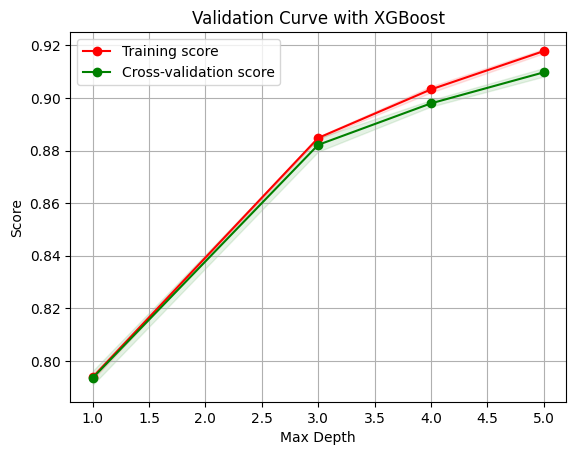

In [10]:
from sklearn.model_selection import validation_curve
param_range = [1, 3, 4, 5]
train_scores, test_scores = validation_curve(
    xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    X_res, y_res, param_name="max_depth", param_range=param_range,
    cv=cv, scoring="f1_weighted", n_jobs=-1)

train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_mean = test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)

plt.figure()
plt.title("Validation Curve with XGBoost")
plt.xlabel("Max Depth")
plt.ylabel("Score")
plt.grid()

plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(param_range, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(param_range, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()


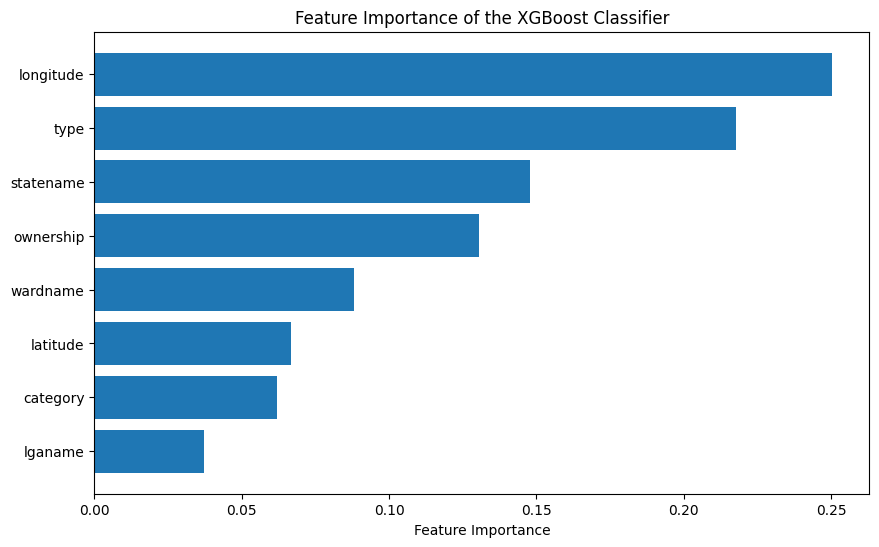

In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV

# Extract feature importances from the best estimator
best_xgb_clf = grid_search.best_estimator_.named_steps['classifier']
feature_importances = best_xgb_clf.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], align='center')
plt.xlabel('Feature Importance')
plt.title('Feature Importance of the XGBoost Classifier')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:13:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:13:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:13:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:13:38] WARNING: /Users/runner/work/xgboost/xgboost/src

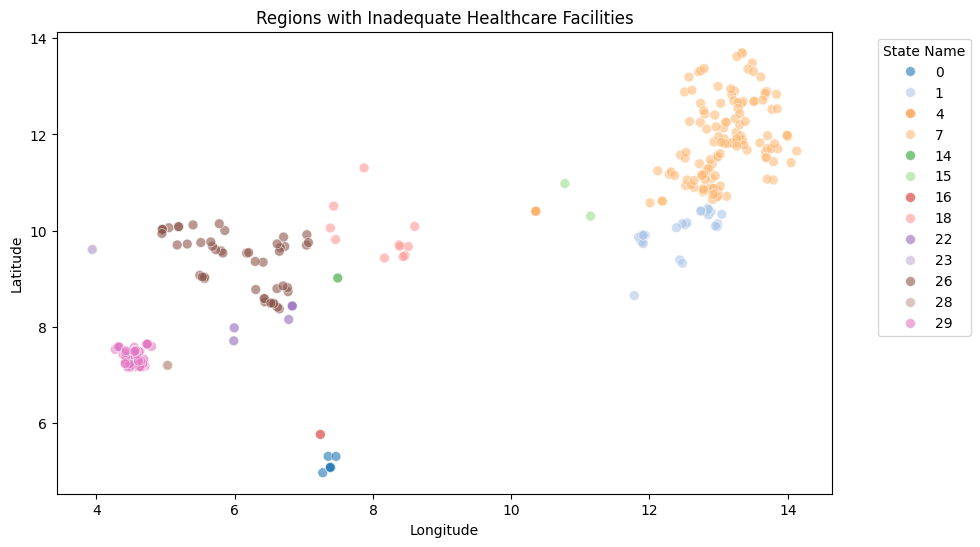

In [10]:
import seaborn as sns
# Train the best classifier on the training set
grid_search.fit(X_train, y_train)

# Predict on the entire dataset
data_selected['predicted_func_stats'] = grid_search.predict(X)
data_selected['predicted_func_stats'] = le_target.inverse_transform(data_selected['predicted_func_stats'])

# Filter out the 'Not Functional' predicted facilities
inadequate_facilities = data_selected[data_selected['predicted_func_stats'] == 'Not Functional']

# Plotting the inadequate facilities
plt.figure(figsize=(10, 6))
sns.scatterplot(x='longitude', y='latitude', hue='statename', data=inadequate_facilities, palette='tab20', s=50, alpha=0.6)
plt.title('Regions with Inadequate Healthcare Facilities')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# Customize the legend
plt.legend(title='State Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

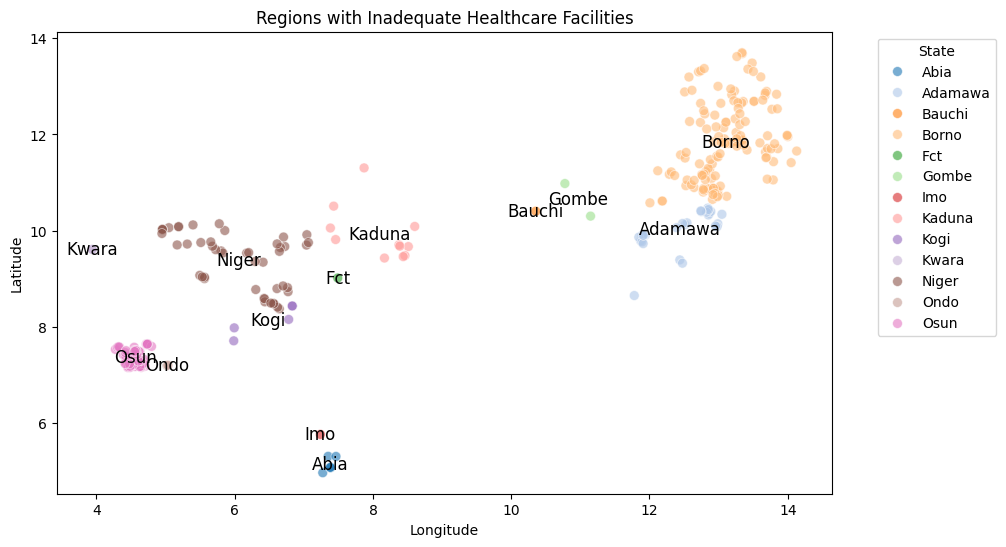

In [11]:
# Create a dictionary mapping from encoded values to original state names
state_code_mapping = dict(zip(data_selected['statename'], data['statename']))

# Filter out the 'Not Functional' predicted facilities
inadequate_facilities1 = data_selected[data_selected['predicted_func_stats'] == 'Not Functional']

# Calculate the center point for each state
state_centers = inadequate_facilities1.groupby('statename')[['latitude', 'longitude']].mean().reset_index()

# Get unique state names for hue order
state_names = data['statename'].unique()

# Create a color palette
palette = sns.color_palette("tab20", len(state_names))
color_mapping = {state: palette[i] for i, state in enumerate(state_names)}

# Plotting the inadequate facilities
plt.figure(figsize=(10, 6))
sns.scatterplot(x='longitude', y='latitude', hue='statename', data=inadequate_facilities1, palette='tab20', s=50, alpha=0.6)
plt.title('Regions with Inadequate Healthcare Facilities')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Annotate state names
for _, row in state_centers.iterrows():
    plt.text(row['longitude'], row['latitude'], state_code_mapping[row['statename']], fontsize=12, ha='center', va='center')

# Adjust the legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = [state_code_mapping[int(label)] for label in labels[0:]]  # Adjust labels
plt.legend(handles=handles[0:], labels=labels, bbox_to_anchor=(1.05, 1), loc='upper left', title='State')

plt.show()

In [ ]:
inadequate_facilities1

In [12]:
import pandas as pd
import os

# Assuming data_selected is already defined and populated
# Filter out the 'Not Functional' predicted facilities
inadequate_facilities = data_selected[data_selected['predicted_func_stats'] == 'Not Functional']

# Define the directory path
directory_path = '/Users/lilianngonadi/Downloads/inadequate_healthcare_facilities'

# Create the directory if it does not exist
os.makedirs(directory_path, exist_ok=True)

# Specify the file path
file_path = os.path.join(directory_path, 'inadequate_healthcare_facilities.csv')

# Save the results to a CSV file
inadequate_facilities.to_csv(file_path, index=False)


In [13]:


# Group by state name and count the number of inadequate facilities
inadequate_facilities_count = inadequate_facilities.groupby('statename').size().reset_index(name='count')

# Sort by the count in descending order
inadequate_facilities_count = inadequate_facilities_count.sort_values(by='count', ascending=False)

# Display the top regions with the most inadequate healthcare facilities
print(inadequate_facilities_count)



    statename  count
3           7    135
12         29     80
10         26     48
1           1     30
7          18     11
0           0      6
8          22      5
9          23      2
5          15      2
11         28      2
2           4      1
4          14      1
6          16      1


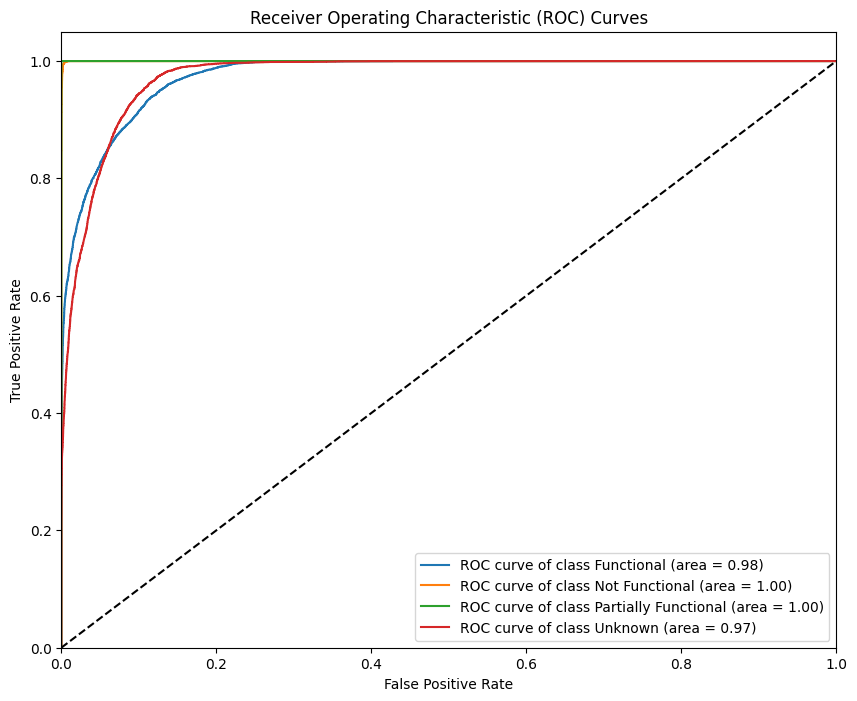

In [14]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities
y_pred_proba = grid_search.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(le_target.classes_)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {le_target.classes_[i]} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()
